In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os


import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from sklearn import preprocessing
from sklearn.metrics import r2_score
import warnings
from sklearn.metrics import cohen_kappa_score
warnings.simplefilter(action="ignore",category=FutureWarning)

pyro.__version__

'1.8.4'

'1.8.4'

# Rational agent

The idea is to train n models where each model is trained using n trials.

extract valid subjects

In [3]:
import extract_correct_csv
valid_sub = extract_correct_csv.extract_only_valid_subject()

read real data of subject #2 (data equals to all subjects)

In [4]:
# read dataset
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_1311/522845498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_1311/522845498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1


In [5]:
data_np = df_rational.to_numpy()

HABITUATION_TRIALS = 16
ACQUISITION_TRIALS = 48
data_all = data_np[16:]
learning_data = data_np[HABITUATION_TRIALS:ACQUISITION_TRIALS] # remove only habituation

In [6]:
data = torch.tensor(data_all)
N = data.shape[0]

In [7]:
array_csplus_simulated = np.load('output/pyro/complete_rational/csplus.npy',allow_pickle=True)
array_csminus_simulated = np.load('output/pyro/complete_rational/csminus.npy',allow_pickle=True)
total_array_simulated = np.load('output/pyro/complete_rational/total.npy',allow_pickle=True)

## shock expectancy simulated

In [8]:
df_ = df[['shock', 'rating', 'morphing level']]
df_['shock'] = df_['shock'].astype(int)
df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
df_['rating'] = df_['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_1311/4112460405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['shock'] = df_['shock'].astype(int)
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_1311/4112460405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_1311/4112460405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [9]:
#remove first 16 trials real data
df_new=df_
#consider only the learning phase
df_learning = df_
df_learning

,shock,rating,morphing level
0,0,0.6,0
1,0,0.6,1
2,0,0.6,1
3,0,0.6,0
4,0,0.6,0
...,...,...,...
155,0,0.2,0
156,0,0.2,0
157,0,0.2,0
158,0,0.2,0


In [10]:
y_plus_real = df_new.loc[df_new['morphing level']==1].rating.values
x_plus_real = np.array(df_new.loc[df_new['morphing level']==1].index)
y_minus_real = df_new.loc[df_new['morphing level']==0].rating.values
x_minus_real = np.array(df_new.loc[df_new['morphing level']==0].index)
y_real=df_new.rating.values

y_plus_train = df_learning.loc[df_learning['morphing level']==1].rating.values
x_plus_train = np.array(df_learning.loc[df_learning['morphing level']==1].index)
y_minus_train = df_learning.loc[df_learning['morphing level']==0].rating.values
x_minus_train = np.array(df_learning.loc[df_learning['morphing level']==0].index)
y_train=df_learning.rating.values

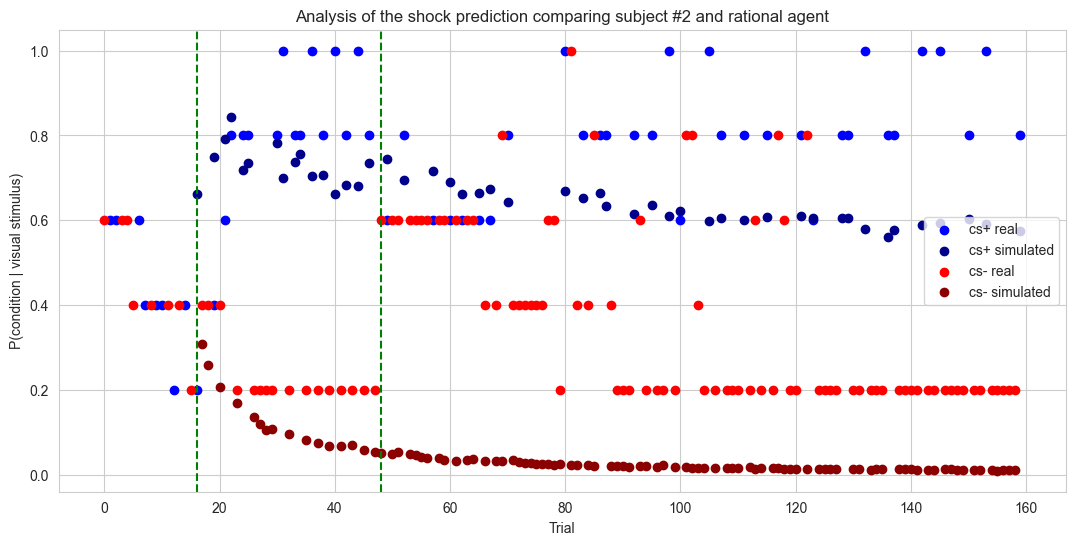

In [11]:
fig = plt.figure(figsize=(13,6))
plt.title('Analysis of the shock prediction comparing subject #2 and rational agent')
plt.scatter(x_plus_real, y_plus_real, color='blue', label='cs+ real')
plt.scatter(array_csplus_simulated[:,0], array_csplus_simulated[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(x_minus_real, y_minus_real, color='red', label='cs- real')
plt.scatter(array_csminus_simulated[:,0], array_csminus_simulated[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()

# correlation

## analysis of the correlation between rational agent and real subject with pearson

In [12]:
# rating between 16-160 trial rational agent
rating_rational = total_array_simulated

In [13]:
df_correlation = pd.DataFrame(columns=['subject','pearson','r2score','person_disc','cohen_disc'])

for sub in valid_sub:
    subj_ = extract_correct_csv.read_correct_subject_csv(sub)
    df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+subj_+'.csv')
    df_sub = df_sub[['shock', 'rating', 'morphing level']]
    df_sub['shock'] = df_sub['shock'].astype(int)
    df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
    df_sub['rating'] = df_sub['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])
    df_sub_learn = df_sub[16:]
    rating_sub = np.array(df_sub_learn['rating'])

    # remove nan
    bad = ~np.logical_or(np.isnan(rating_sub), np.isnan(rating_rational))
    rating_sub_ = np.compress(bad, rating_sub)
    rating_rational_ = np.compress(bad, rating_rational)

    #discretization of rating rational
    round_vector = np.array([0.2, 0.4, 0.6, 0.8, 1])
    rating_rational_discr = np.round(rating_rational_ / 0.2) * 0.2
    rating_rational_discr = np.clip(rating_rational_discr, round_vector.min(), round_vector.max())

    #pearson corr coeff
    pearson = round(np.corrcoef(rating_sub_,rating_rational_)[0][1],2)

    #r2 score
    r2 = round(r2_score(rating_sub_,rating_rational_),2)

    #pearson discr
    pearson_disc = round(np.corrcoef(rating_sub_,rating_rational_discr)[0][1],2)

    #cohen kappa discr
    cohen_disc = round(cohen_kappa_score(rating_sub_*10,rating_rational_discr*10),2)

    # write line
    df_tmp = pd.DataFrame({'subject':sub,'pearson':pearson,'r2score':r2,'person_disc':pearson_disc,'cohen_disc':cohen_disc},index=np.arange(1))
    df_correlation = pd.concat([df_correlation,df_tmp])


sias_df = pd.read_csv('data/sias_score.csv').drop(columns='social_anxiety')
sias_df['subject'] = [float(x) for x in sias_df['subject']]

lds_df = pd.read_csv('data/lds_subjects.csv')
lds_df['subject'] = [float(x) for x in lds_df['subject']]

df_correlation['subject'] = [float(x) for x in df_correlation['subject']]

df_corr_ = pd.concat([sias_df.set_index('subject'), lds_df.set_index('subject'), df_correlation.set_index('subject')], axis=1).reset_index()

# drop nan
lds_df['subject'] = [float(x) for x in lds_df['subject']]

In [17]:
merged_df = pd.concat([sias_df.set_index('subject'), lds_df.set_index('subject'), df_correlation.set_index('subject')], axis=1)
merged_df = merged_df.reset_index()
merged_df

,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,1.0,21.0,0.201,0.31,-4.44,0.31,0.04
1,2.0,11.0,0.828,0.71,-0.39,0.70,0.25
2,3.0,30.0,0.504,NaN,NaN,NaN,NaN
3,4.0,12.0,0.111,0.41,-1.49,0.40,0.05
4,5.0,30.0,0.953,0.70,-0.26,0.68,0.25
5,6.0,8.0,1.312,0.72,0.18,0.72,0.28
6,7.0,25.0,0.535,0.69,-0.73,0.70,0.22
7,8.0,6.0,0.583,NaN,NaN,NaN,NaN
8,9.0,NaN,NaN,NaN,NaN,NaN,NaN
9,10.0,10.0,0.682,NaN,NaN,NaN,NaN


In [18]:
df_corr_notna = merged_df[merged_df['pearson'].notna()]
df_corr_notna = df_corr_notna[merged_df['lds'].notna()]
df_corr_notna = df_corr_notna[merged_df['sias_score'].notna()]
df_corr_notna

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_1311/3410993754.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr_notna = df_corr_notna[merged_df['lds'].notna()]
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_1311/3410993754.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr_notna = df_corr_notna[merged_df['sias_score'].notna()]


,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,1.0,21.0,0.201,0.31,-4.44,0.31,0.04
1,2.0,11.0,0.828,0.71,-0.39,0.70,0.25
3,4.0,12.0,0.111,0.41,-1.49,0.40,0.05
4,5.0,30.0,0.953,0.70,-0.26,0.68,0.25
5,6.0,8.0,1.312,0.72,0.18,0.72,0.28
6,7.0,25.0,0.535,0.69,-0.73,0.70,0.22
12,13.0,16.0,0.141,0.39,-3.38,0.38,0.04
14,15.0,16.0,0.693,0.63,-0.12,0.64,0.29
15,16.0,55.0,0.621,0.36,-1.30,0.34,0.07
16,17.0,16.0,-0.382,0.25,-2.57,0.26,0.09


In [20]:
#extract subject with high value lds and lower lds
lds_ = df_corr_notna.sort_values('lds').reset_index(drop=True)
lower_lds = lds_[:7]
higher_lds = lds_[-7:]

# Analysis subject with more fear gen vs subjects less fear gen

In [21]:
sias_ = df_corr_notna.sort_values('sias_score',ascending=True).reset_index().drop(columns='index')
lower_sias = sias_[:5]
sias_ = df_corr_notna.sort_values('sias_score',ascending=False).reset_index().drop(columns='index')
higher_sias= sias_[:5]

# Analysis subject more fear gen vs less fear gen

In [22]:
l_low_p = lower_lds['pearson'].median()
l_hig_p = higher_lds['pearson'].median()
l_low_r = lower_lds['r2score'].median()
l_hig_r = higher_lds['r2score'].median()

print('Correlation between 7 more/less fear gen subjects with the rational agent\n')
print('Pearson\nHigh fear gen: ',l_low_p, ' Low fear gen:',l_hig_p)
print('\nR2score\nHigh fear gen: ',l_low_r, ' Low fear gen:',l_hig_r)

Correlation between 7 more/less fear gen subjects with the rational agent

Pearson
High fear gen:  0.31  Low fear gen: 0.79

R2score
High fear gen:  -2.57  Low fear gen: 0.1


# Analysis subject more anxiety vs less anxiety

In [23]:
lower_sias

,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,26.0,3.0,0.834,0.66,-0.07,0.66,0.23
1,51.0,6.0,0.641,0.68,-0.22,0.67,0.35
2,6.0,8.0,1.312,0.72,0.18,0.72,0.28
3,2.0,11.0,0.828,0.71,-0.39,0.70,0.25
4,4.0,12.0,0.111,0.41,-1.49,0.40,0.05


In [24]:
s_low_p = lower_sias['pearson'].median()
s_hig_p = higher_sias['pearson'].median()

s_low_r = lower_sias['r2score'].median()
s_hig_r = higher_sias['r2score'].median()

print('Correlation between 5 more/less anxiety subjects with the rational agent\n')
print('Pearson\nHigh anxiety: ',s_hig_p, ' Low anxiety:',s_low_p)
print('\nR2score\nHigh anxiety: ',s_hig_r, ' Low anxiety:',s_low_r)

Correlation between 5 more/less anxiety subjects with the rational agent

Pearson
High anxiety:  0.4  Low anxiety: 0.68

R2score
High anxiety:  -1.3  Low anxiety: -0.22


# Analysis subject with more anxiety vs subjects less anxiety

In [25]:
sias_

,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,16.0,55.0,0.621,0.36,-1.30,0.34,0.07
1,23.0,37.0,0.279,0.40,-1.56,0.40,0.17
2,46.0,31.0,0.006,0.02,-2.83,0.01,0.01
3,27.0,31.0,1.328,0.91,0.50,0.88,0.45
4,5.0,30.0,0.953,0.70,-0.26,0.68,0.25
5,7.0,25.0,0.535,0.69,-0.73,0.70,0.22
6,43.0,25.0,1.043,0.79,-0.03,0.78,0.25
7,48.0,24.0,0.365,0.53,-0.98,0.53,0.13
8,50.0,23.0,0.443,0.21,-2.47,0.19,0.09
9,33.0,22.0,0.969,0.68,-0.13,0.68,0.30


In [26]:
lower_sias['pearson'].median()

0.68

In [27]:
higher_sias['pearson'].median()

0.4

# autorank

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table


# SIAS: low vs high. pearson corr coeff

In [ ]:
total_array_simulated = np.load('output/pyro/complete_rational/total.npy', allow_pickle=True)
values = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
discretized_data = np.digitize(total_array_simulated, values)

In [30]:
sias_autorank = pd.DataFrame(columns=('pearson low','pearson high'))
sias_autorank['pearson low'] = lower_sias['pearson']
sias_autorank['pearson high'] = higher_sias['pearson']

result = autorank(sias_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
              median   mad ci_lower ci_upper effect_size   magnitude  p_equal  \
pearson low     0.68  0.03     0.41     0.72         0.0  negligible      NaN   
pearson high    0.40   0.3     0.02     0.91    0.885864       large    0.013   

              p_smaller      decision  
pearson low         NaN            NA  
pearson high     0.8384  inconclusive  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=False
pvals_shapiro=[0.015134504064917564, 0.9022369384765625]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=5
posterior_matrix=
             pearson low             pearson high
pearson low          NaN  (0.8384, 0.013, 0.1486)
pearson high         NaN                      NaN
decision_matrix=
               pearson low  pearson high
pearson low            NaN  inconclusive
pearson high  inconclusive           NaN
rope=0.1
rope_mode=effsize
effect_size=akinshin_gamma)


In [31]:
result[0]

,median,mad,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
pearson low,0.68,0.03,0.41,0.72,0.0,negligible,NaN,NaN,NA
pearson high,0.40,0.3,0.02,0.91,0.885864,large,0.013,0.8384,inconclusive


# SIAS: low vs high. r2 score

In [ ]:
sias_autorank = pd.DataFrame(columns=('r2 low','r2 high'))
sias_autorank['r2 low'] = lower_sias['r2score']
sias_autorank['r2 high'] = higher_sias['r2score']

result = autorank(sias_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
          mean       std  ci_lower  ci_upper effect_size   magnitude  p_equal  \
r2 high -1.612  1.824409 -5.132331  1.908331         0.0  negligible      NaN   
r2 low  -1.706  1.764052 -5.109867  1.697867    0.052383  negligible  0.21708   

         p_smaller      decision  
r2 high        NaN            NA  
r2 low     0.55234  inconclusive  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=True
pvals_shapiro=[0.11953478306531906, 0.2857353091239929]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=5
posterior_matrix=
        r2 high                       r2 low
r2 high     NaN  (0.55234, 0.21708, 0.23058)
r2 low      NaN                          NaN
decision_matrix=
              r2 high        r2 low
r2 high           NaN  inconclusive
r2 low   inconclusive           NaN
rope=0.1
rope_mode=effsize
effect_size=cohen_d)


In [ ]:
result[0]

,mean,std,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
r2 high,-1.612,1.824409,-5.132331,1.908331,0.0,negligible,NaN,NaN,NA
r2 low,-1.706,1.764052,-5.109867,1.697867,0.052383,negligible,0.21708,0.55234,inconclusive


# LDS: low vs high. pearson corr coef

In [ ]:
lds_autorank = pd.DataFrame(columns=('pearson low','pearson high'))
lds_autorank['pearson low'] = lower_lds['pearson']
lds_autorank['pearson high'] = higher_lds['pearson']

result = autorank(lds_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
                  mean       std  ci_lower  ci_upper effect_size   magnitude  \
pearson low   0.475714  0.302261  0.073436  0.877993         0.0  negligible   
pearson high       NaN       NaN       NaN       NaN         NaN       large   

              p_equal  p_smaller decision  
pearson low       NaN        NaN       NA  
pearson high      0.0        1.0  smaller  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=True
pvals_shapiro=[0.4858570694923401, 1.0]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=7
posterior_matrix=
             pearson low     pearson high
pearson low          NaN  (1.0, 0.0, 0.0)
pearson high         NaN              NaN
decision_matrix=
             pearson low pearson high
pearson low          NaN      smaller
pearson high      larger          NaN
rope=0.1
rope_mode=effsize
effect_size=cohen_d)


In [ ]:
result[0]

,mean,std,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
pearson low,0.475714,0.302261,0.073436,0.877993,0.0,negligible,NaN,NaN,NA
pearson high,NaN,NaN,NaN,NaN,NaN,large,0.0,1.0,smaller


# LDS: low vs high. r2 corr coef

In [ ]:
lds_autorank = pd.DataFrame(columns=('r2score low','r2score high'))
lds_autorank['r2score low'] = lower_lds['r2score']
lds_autorank['r2score high'] = higher_lds['r2score']

result = autorank(lds_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
                  mean       std  ci_lower ci_upper effect_size   magnitude  \
r2score low  -1.598571  1.690635 -3.848633  0.65149         0.0  negligible   
r2score high       NaN       NaN       NaN      NaN         NaN       large   

              p_equal  p_smaller decision  
r2score low       NaN        NaN       NA  
r2score high      0.0        1.0  smaller  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=True
pvals_shapiro=[0.4031602442264557, 1.0]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=7
posterior_matrix=
             r2score low     r2score high
r2score low          NaN  (1.0, 0.0, 0.0)
r2score high         NaN              NaN
decision_matrix=
             r2score low r2score high
r2score low          NaN      smaller
r2score high      larger          NaN
rope=0.1
rope_mode=effsize
effect_size=cohen_d)


In [ ]:
result[0]

,mean,std,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
r2score low,-1.598571,1.690635,-3.848633,0.65149,0.0,negligible,NaN,NaN,NA
r2score high,NaN,NaN,NaN,NaN,NaN,large,0.0,1.0,smaller


In [32]:
std = 0.3
means = [0.2, 0.3, 0.5, 0.8, 0.85, 0.9]
sample_size = 50
data = pd.DataFrame()
for i, mean in enumerate(means):
    data['pop_%i' % i] = np.random.normal(mean, std, sample_size).clip(0, 1)
data

,pop_0,pop_1,pop_2,pop_3,pop_4,pop_5
0,0.009526,0.183090,0.236843,0.940886,1.000000,1.000000
1,0.000000,0.540710,0.406915,0.679139,1.000000,0.580386
2,0.000000,0.362501,0.355781,0.860031,1.000000,0.998530
3,0.472447,0.000000,0.764067,1.000000,0.397133,0.942494
4,0.904224,0.922026,0.384156,0.776090,0.315976,0.711287
5,0.477247,0.550683,0.000000,0.793283,1.000000,1.000000
6,0.177065,0.000000,0.320301,0.991390,0.868256,1.000000
7,0.229477,0.000000,0.589883,0.634939,0.788666,0.638636
8,0.366011,0.265772,0.731235,0.748735,0.542982,1.000000
9,0.176256,0.775719,0.241076,0.438061,1.000000,0.595861


# Analysis sliding window K

In [ ]:
k_wind = [2, 5, 10, 25, 50, 100, 150]
for k in list(k_wind):

    array_csplus_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_csplus.npy',allow_pickle=True)
    array_csminus_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_csminus.npy',allow_pickle=True)
    total_array_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_total.npy',allow_pickle=True)

    rating_rational = total_array_simulated
    rating_rational = rating_rational[16:]

    df_correlation = pd.DataFrame(columns=['subject','pearson'])

    for sub in valid_sub:
        subj_ = extract_correct_csv.read_correct_subject_csv(sub)
        df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+subj_+'.csv')
        df_sub = df_sub[['shock', 'rating', 'morphing level']]
        df_sub['shock'] = df_sub['shock'].astype(int)
        df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
        df_sub['rating'] = df_sub['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])
        df_sub_learn = df_sub[16:]
        rating_sub = np.array(df_sub_learn['rating'])
        bad = ~np.logical_or(np.isnan(rating_sub), np.isnan(rating_rational))
        rating_sub_ = np.compress(bad, rating_sub)
        rating_rational_ = np.compress(bad, rating_rational)
        pearson = round(np.corrcoef(rating_sub_,rating_rational_)[0][1],2)
        df_correlation = df_correlation.append({'subject':sub,'pearson':pearson},ignore_index=True)
    sias_df = pd.read_csv('data/sias_score.csv').drop(columns='social_anxiety')
    sias_df['subject'] = [float(x) for x in sias_df['subject']]

    lds_df = pd.read_csv('data/lds_subjects.csv')

    lds_df['subject'] = [float(x) for x in lds_df['subject']]
    df_corr = df_correlation.join(lds_df, lsuffix='', rsuffix='_other',how='inner').drop(columns='subject_other')
    df_corr_ = df_corr.join(sias_df,lsuffix='', rsuffix='_other',how='inner').drop(columns='subject_other')
    df_corr_notna = df_corr_[df_corr_['pearson'].notna()]
    df_corr_notna = df_corr_notna[df_corr_['lds'].notna()]
    df_corr_notna = df_corr_notna[df_corr_['sias_score'].notna()]
    lds_ = df_corr_notna.sort_values('lds').reset_index().drop(columns='index')
    lower_lds = lds_[:7]
    higher_lds = lds_[-7:]

    print('\n\n--------------- K = '+str(k)+' ---------------')

    print('7 subj less lds corr with rational agent:',lower_lds['pearson'].median())
    print('7 subj more lds corr with rational agent:',higher_lds['pearson'].median())

    sias_ = df_corr_notna.sort_values('sias_score',ascending=True).reset_index().drop(columns='index')
    lower_sias = sias_[:7]
    sias_ = df_corr_notna.sort_values('sias_score',ascending=False).reset_index().drop(columns='index')
    higher_sias= sias_[:7]
    print()
    print('7 subj less sias corr with rational agent:',lower_sias['pearson'].median())
    print('7 subj more sias corr with rational agent:',higher_sias['pearson'].median())



--------------- K = 2 ---------------
7 subj less lds corr with rational agent: 0.32
7 subj more lds corr with rational agent: 0.48

7 subj less sias corr with rational agent: 0.48
7 subj more sias corr with rational agent: 0.35


--------------- K = 5 ---------------
7 subj less lds corr with rational agent: 0.39
7 subj more lds corr with rational agent: 0.57

7 subj less sias corr with rational agent: 0.57
7 subj more sias corr with rational agent: 0.4


--------------- K = 10 ---------------
7 subj less lds corr with rational agent: 0.45
7 subj more lds corr with rational agent: 0.63

7 subj less sias corr with rational agent: 0.63
7 subj more sias corr with rational agent: 0.43


--------------- K = 25 ---------------
7 subj less lds corr with rational agent: 0.48
7 subj more lds corr with rational agent: 0.69

7 subj less sias corr with rational agent: 0.66
7 subj more sias corr with rational agent: 0.41


--------------- K = 50 ---------------
7 subj less lds corr with rational

In [ ]:
df_corr_notna['sias_score'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['sias_score']])[0]]
df_corr_notna['lds'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['lds']])[0]]
df_corr_notna['pearson'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['pearson']])[0]]


In [ ]:
df_corr_notna['subject'] = [int(x) for x in df_corr_notna['subject']]

In [ ]:
lds_ = df_corr_notna.sort_values('lds').reset_index().drop(columns='index')
lower_lds = lds_[:5]
higher_lds = lds_[-5:]

In [ ]:
subjects = tuple(df_corr_notna['subject'])

In [ ]:
values = {'pearson':(),'lds':(),'sias':()}
for index,row in df_corr_notna.iterrows():
    new_p = values['pearson'] + (row['pearson'],)
    values.update({'pearson':new_p})
    new_l = values['lds'] + (row['lds'],)
    values.update({'lds':new_l})
    new_s = values['sias'] + (row['sias_score'],)
    values.update({'sias':new_s})

In [ ]:
values_no_sias = {'pearson':(),'lds':()}
for index,row in df_corr_notna.iterrows():
    new_p = values_no_sias['pearson'] + (row['pearson'],)
    values_no_sias.update({'pearson':new_p})
    new_l = values_no_sias['lds'] + (row['lds'],)
    values_no_sias.update({'lds':new_l})

In [ ]:
subjects = tuple(df_corr_notna['subject'])
values_no_lds = {'pearson': (), 'sias': ()}
for index, row in df_corr_notna.iterrows():
    new_p = values_no_lds['pearson'] + (row['pearson'],)
    values_no_lds.update({'pearson': new_p})
    new_s = values_no_lds['sias'] + (row['sias_score'],)
    values_no_lds.update({'sias': new_s})

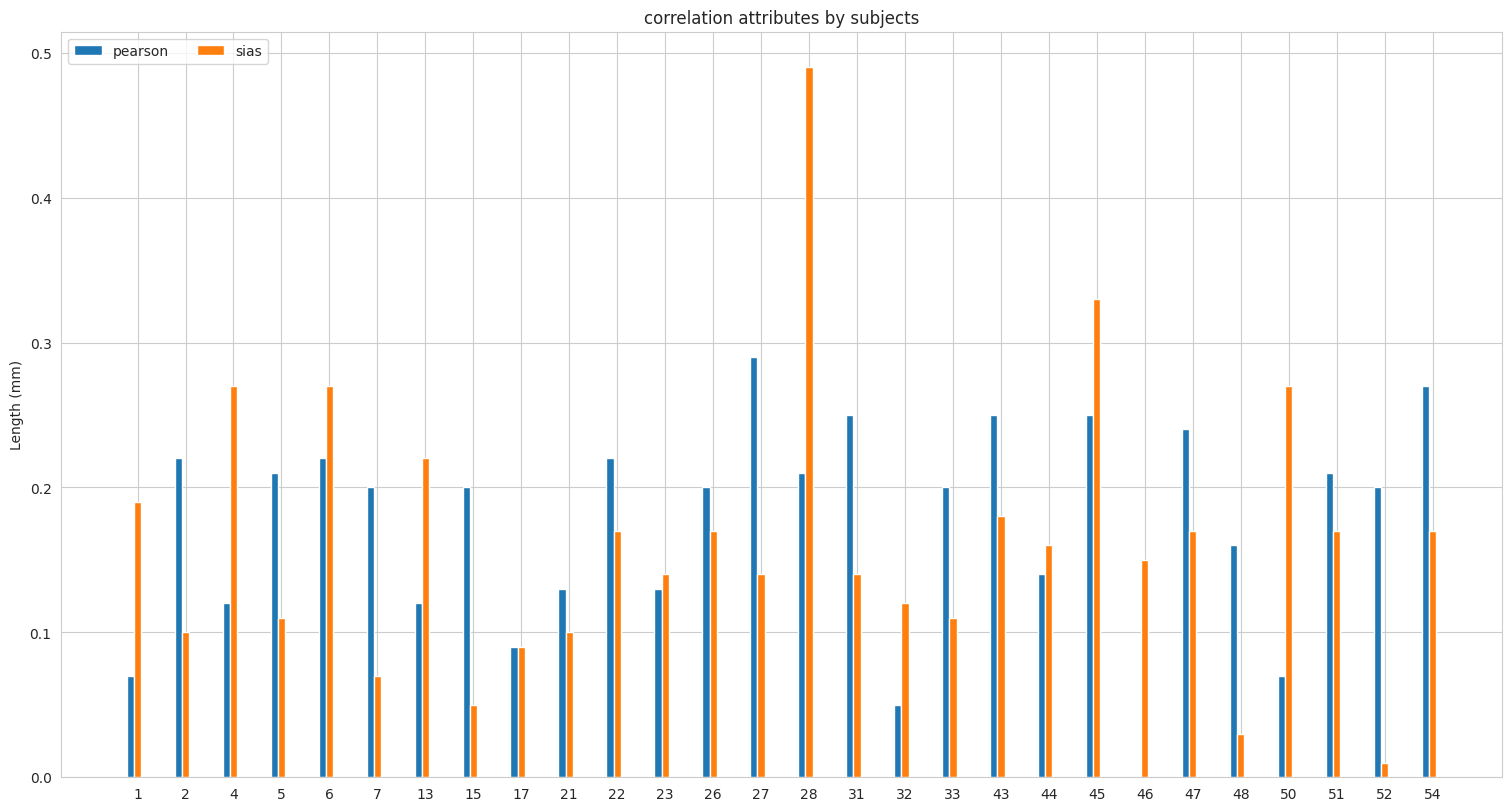

In [ ]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values_no_lds.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

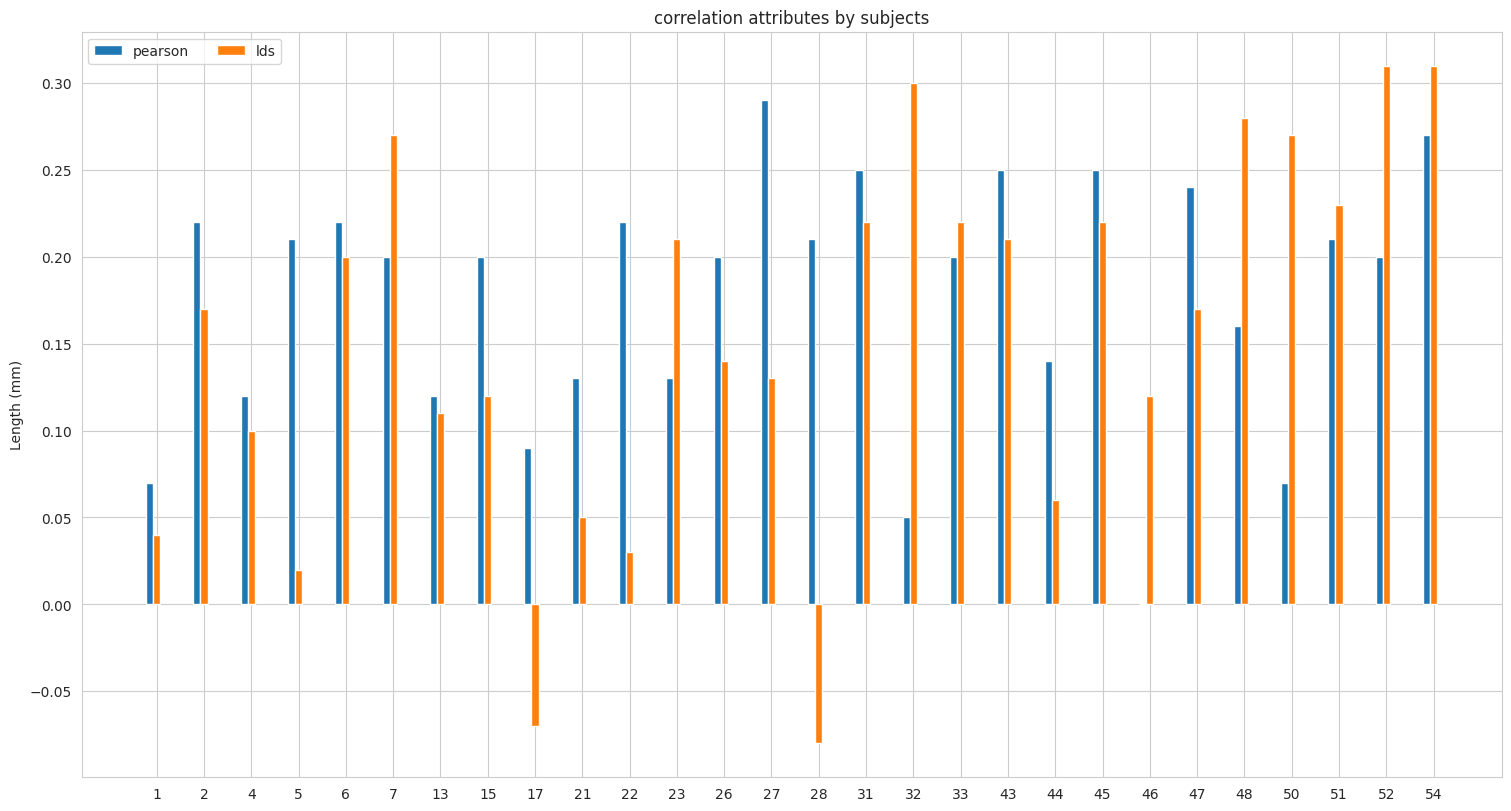

In [ ]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values_no_sias.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

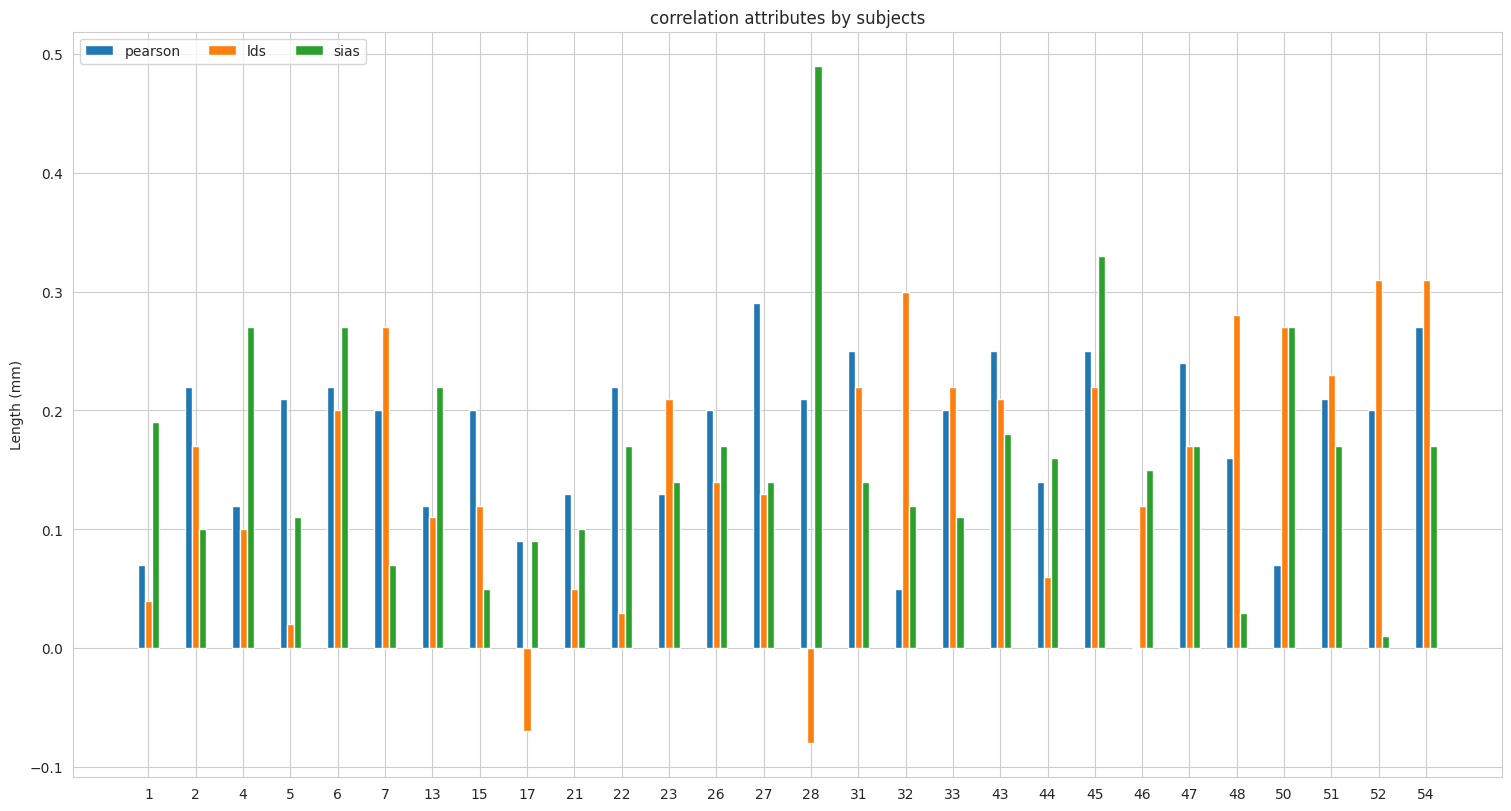

In [ ]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

# rational agent sliding window

The idea is to have a rational agent with a limited memory over previous trials.
k = param sliding window dimension


In [ ]:
import extract_correct_csv
valid_sub = extract_correct_csv.extract_only_valid_subject()

In [ ]:
# read dataset
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1

/tmp/ipykernel_50788/522845498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
/tmp/ipykernel_50788/522845498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1


In [ ]:
data_np = df_rational.to_numpy()


def counter_window(data, k=0):
    N = data.shape[0]
    counter = torch.zeros((N,4))
    for i in range(len(data)):
        dict_ = {'[0 0]':0, '[0 1]': 0, '[1 0]':0, '[1 1]':0}
        if k == 0 or k > i:
            tmp_data = data[:i+1]
        else:
            tmp_data = data[i-k:i+1]
            #print('im here')
        # count occurencies
        for x in tmp_data:
            dict_[str(x)] += 1
        values = np.array(list(dict_.values()))
        counter[i] = torch.tensor(values)
    return counter

In [ ]:
counter = counter_window(data_np, 3)

counter = counter.reshape((len(data_np), 2, 2))
counter.shape

torch.Size([160, 2, 2])

In [ ]:
# categorical/multinomial distribution

# uniform prior
prior_counts = torch.ones((2,2))


#model
def model(data):
    prior = pyro.sample("prior", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("likelihood", dist.Multinomial(total_counts, prior), obs=data)


nuts_kernel = NUTS(model)
num_samples, warmup_steps = (300, 200)

mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=True)
all_means = []

# sampling
for i in range(len(counter)):
    mcmc.run(counter[i])
    hmc_samples = {k: v.detach().cpu().numpy()
                   for k, v in mcmc.get_samples().items()}
    means = hmc_samples['prior'].mean(axis=0)
    stds = hmc_samples['prior'].std(axis=0)
    print('observation: ', data_np[i])
    print('probabilities: ', means)
    all_means.append(means)

observation:  [0 0]
probabilities:  [[0.662328   0.33767188]
 [0.49292728 0.50707275]]
observation:  [1 0]
probabilities:  [[0.6694433  0.33055627]
 [0.6712761  0.32872382]]
observation:  [1 0]
probabilities:  [[0.65302664 0.34697324]
 [0.78036624 0.21963356]]
observation:  [0 0]
probabilities:  [[0.7436167  0.2563837 ]
 [0.76004255 0.2399574 ]]
observation:  [0 0]
probabilities:  [[0.7432792  0.25672087]
 [0.7482905  0.25170964]]
observation:  [0 0]
probabilities:  [[0.80399144 0.19600855]
 [0.6959044  0.30409557]]
observation:  [1 0]
probabilities:  [[0.8010759  0.19892392]
 [0.6719622  0.3280377 ]]
observation:  [1 0]
probabilities:  [[0.7479752  0.25202492]
 [0.7363099  0.26369032]]
observation:  [0 0]
probabilities:  [[0.7585082  0.24149157]
 [0.7492258  0.25077406]]
observation:  [1 0]
probabilities:  [[0.6427093  0.35729074]
 [0.7984205  0.20157923]]
observation:  [1 0]
probabilities:  [[0.69662166 0.3033785 ]
 [0.8006772  0.19932285]]
observation:  [0 0]
probabilities:  [[0.746

## Deep Markov model

![example](https://pyro.ai/examples/_static/img/model.png)

In [ ]:
import argparse
import logging
import time
from os.path import exists
import numpy as np
import torch
import torch.nn as nn
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import (
    SVI,
    JitTrace_ELBO,
    Trace_ELBO,
    TraceEnum_ELBO,
    TraceTMC_ELBO,
    config_enumerate,
)
from pyro.optim import ClippedAdam

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
# emission function (Emit in the figure)
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood p(x_t|z_t)

    """
    def __init__(self, input_dim, z_dim, emission_dim):
        super().__init__()
        # emission_dim is the number of hidden units in the neural network
        # three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # two non linear used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t, we return the vector of probabilities 'ps' that parametrizes the bernoulli distribution p(x_t|z_t)
        Taken together the elements of ps encode which notes we expect to observe at time t given the state of the system (as encoded in z_t).
        """
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        ps = self.sigmoid(self.lin_hidden_to_input(h2))
        return ps

In [ ]:
# gated transition (Trans in the figure above)
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability p(z_t | z_{t-1})
    """
    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # six linear transform
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)

        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the IDENTITY FUNCTION
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)

        # three non linear
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()


    def forward(self, z_t_1):
        """
        Given the latent z_{t-1} corresponding to the time step t-1 we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution p(z_t | z_{t-1})
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = self.sigmoid(self.lin_gate_hidden_to_z(_gate))

        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)

        # assemble the actual mean used to sample z_t, which mixes a linear transformation of z_{t-1} with the proposed mean
        # modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean

        # compute the scale used to sample z_t, using the proposed
        # mean from above as input. the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))

        # return loc, scale which can be fed into Normal (mean and covariance of our Gaussian)
        return loc, scale

In [ ]:
# simple model (not working)
def model(...):
    # initializer
    z_prev = self.z_0

    # sample the latents z and observed x's one time step at a time
    for t in range(1, T_max + 1):
        # the next two lines of code sample z_t ~ p(z_t | z_{t-1}).
        # first compute the parameters of the diagonal gaussian
        # distribution p(z_t | z_{t-1})
        z_loc, z_scale = self.trans(z_prev)
        # then sample z_t according to dist.Normal(z_loc, z_scale)
        z_t = pyro.sample("z_%d" % t, dist.Normal(z_loc, z_scale))

        # compute the probabilities that parameterize the bernoulli likelihood
        emission_probs_t = self.emitter(z_t)
        # the next statement instructs pyro to observe x_t according to the
        # bernoulli distribution p(x_t|z_t)
        pyro.sample("obs_x_%d" % t,
                    dist.Bernoulli(emission_probs_t),
                    obs=mini_batch[:, t - 1, :])
        # the latent sampled at this time step will be conditioned upon
        # in the next time step so keep track of it
        z_prev = z_t

### Agent example

To define a hidden Markov Model (HMM) for this scenario, we need to identify the key components of an HMM:
1.	States: In our case, the state is whether the agent is in a shocked state or not. We will use 0 to represent a non-shocked state and 1 to represent a shocked state.
2.	Observations: The observation is whether the agent sees an aggressive or non-aggressive image. We will use 0 to represent a non-aggressive image and 1 to represent an aggressive image.
3.	Transition probabilities: The transition probabilities determine the probability of moving from one state to another. In our case, the transition probabilities will depend on the current state and the shock received. Specifically, if the agent is in a non-shocked state and receives a shock, there is a high probability of transitioning to the shocked state. Conversely, if the agent is in the shocked state and does not receive a shock, there is a high probability of transitioning to the non-shocked state.
4.	Emission probabilities: The emission probabilities determine the probability of observing a particular image given the current state. In our case, the emission probabilities will depend on the current state. Specifically, if the agent is in the non-shocked state, there is a high probability of observing a non-aggressive image, and if the agent is in the shocked state, there is a high probability of observing an aggressive image.

In [49]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, SVI


def transition_model(state):
    p_stay = 0.7 if state else 0.9
    p_switch = 1 - p_stay
    return pyro.sample('state_transition', dist.Categorical(torch.tensor([p_stay, p_switch])))


def emission_model(state):
    p_emission = 0.9 if state else 0.1
    return pyro.sample('emission', dist.Bernoulli(torch.tensor(p_emission)))


def initial_model():
    return pyro.sample('initial_state', dist.Categorical(torch.tensor([0.5, 0.5])))


def model(stimuli, shock, initial_state):
    states = [pyro.sample('init_state', dist.Categorical(initial_state))]
    emissions = [emission_model(states[0]).item()]
    for i in range(1, len(stimuli)):
        states.append(transition_model(states[i-1]).item())
        emissions.append(emission_model(states[i]).item())
    return states, emissions


def guide(stimuli, shock, initial_state, states, emissions):
    for i in range(len(stimuli)):
        states[i] = pyro.sample('state_{}'.format(i), dist.Bernoulli(torch.tensor(0.5)))
        emissions[i] = pyro.sample('emission_{}'.format(i), dist.Bernoulli(torch.tensor(0.5)))


stimuli = torch.tensor([0, 0, 0, 1, 1, 0, 1, 1, 0])
shock = torch.tensor([0, 0, 0, 1, 1, 0, 0, 1, 0])
initial_state = torch.tensor([0.5, 0.5])

optimizer = pyro.optim.Adam({'lr': 0.1})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

for i in range(1000):
    states, emissions = model(stimuli, shock, initial_state)
    loss = svi.step(stimuli, shock, initial_state, states, emissions)
    if i % 100 == 0:
        print("step {}: loss = {}".format(i, loss))


TypeError: model() takes 3 positional arguments but 5 were given

## Rational agent discretisation

In [ ]:
valid_subjects = extract_correct_csv.extract_only_valid_subject()
len(valid_subjects)

In [ ]:
total_array_simulated = np.load('output/pyro/complete_rational/total.npy',allow_pickle=True)
total_array_simulated

In [ ]:
values = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
discretized_data = np.digitize(total_array_simulated, values)
print(discretized_data.shape)


df_global = pd.DataFrame(columns=['Subject', 'Rating rational', 'Rating real'])

for sub in valid_subjects:
    string_sub = extract_correct_csv.read_correct_subject_csv(sub)
    df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+string_sub+'.csv')
    df_sub = df_sub[16:]
    tmp_df = pd.DataFrame({'Subject': sub, 'Rating rational': discretized_data, 'Rating real': df_sub['rating']})
    df_global = pd.concat([df_global, tmp_df])

df_global = df_global.reset_index(drop=True)

In [ ]:
# useless up to now
'''df_global = df_global.groupby('Subject', as_index=False).agg({'Rating rational': lambda x: x.tolist(), 'Rating real': lambda x: x.tolist()})
df_global['Rating rational'] = df_global['Rating rational'].apply(lambda x: np.array(x))
df_global['Rating real'] = df_global['Rating real'].apply(lambda x: np.array(x))'''

In [ ]:
valid_subjects = df_global.Subject.unique()
valid_subjects

In [ ]:
from pyirr import intraclass_correlation


In [ ]:
dict_results = {}
for x in valid_subjects:
    df_sub_ = df_global[df_global.Subject == x].dropna().drop(columns=['Subject']).reset_index(drop=True)
    df_sub_['Rating rational'] = df_sub_['Rating rational'].astype(float)
    result = intraclass_correlation(df_sub_).value
    dict_results[x] = result

dict_results


In [ ]:
df_icc = pd.DataFrame(list(dict_results.items()), columns=['Subject', 'ICC'])
df_icc

In [ ]:
def anxious_subjects(path, n, type='top'):
    '''

    :param path: path sias score or linear deviation score
    :param n: number of subjects
    :param type: 'top' or 'bot'
    :return: top or bot n subjects sorted by sias score
    '''
    valid_subjects = extract_correct_csv.extract_only_valid_subject()
    df = pd.read_csv(path).dropna().reset_index(drop=True)
    df = df[df.subject.isin(valid_subjects)]
    df['subject'] = [int(x) for x in df['subject']]
    if type=='top':
        return df.sort_values(by=df.columns[1], ascending=False).subject[:n].values
    else:
        return df.sort_values(by=df.columns[1], ascending=False).subject[-n:].values


In [ ]:
path_sias = 'data/sias_score.csv'
path_lds = 'data/lds_subjects.csv'

len_sub = 6
top_lds = anxious_subjects(path_lds, len_sub, 'top')
bot_lds = anxious_subjects(path_lds, len_sub, 'bot')

top_sias = anxious_subjects(path_sias, len_sub)
bot_sias = anxious_subjects(path_sias, len_sub, 'bot')

In [ ]:
mean_top_sias = df_icc[df_icc.Subject.isin(top_sias)]['ICC'].mean()
mean_bot_sias = df_icc[df_icc.Subject.isin(bot_sias)]['ICC'].mean()
mean_top_lds = df_icc[df_icc.Subject.isin(top_lds)]['ICC'].mean()
mean_bot_lds = df_icc[df_icc.Subject.isin(bot_lds)]['ICC'].mean()

In [ ]:
print(f'Average of the first {len_sub} subjects with higher sias score: {round(mean_top_sias, 2)}')
print(f'Average of the first {len_sub} subjects with lower sias score: {round(mean_bot_sias, 2)}')
print(f'Average of the first {len_sub} subjects with higher linear deviation score: {round(mean_top_lds,2)}')
print(f'Average of the first {len_sub} subjects with lower linear deviation score: {round(mean_bot_lds, 2)}')